In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import pandas as pd 
import numpy as np 
import os 
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


In [8]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path','label'])
data['path'] = path
data['label'] = label

In [9]:
data


,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


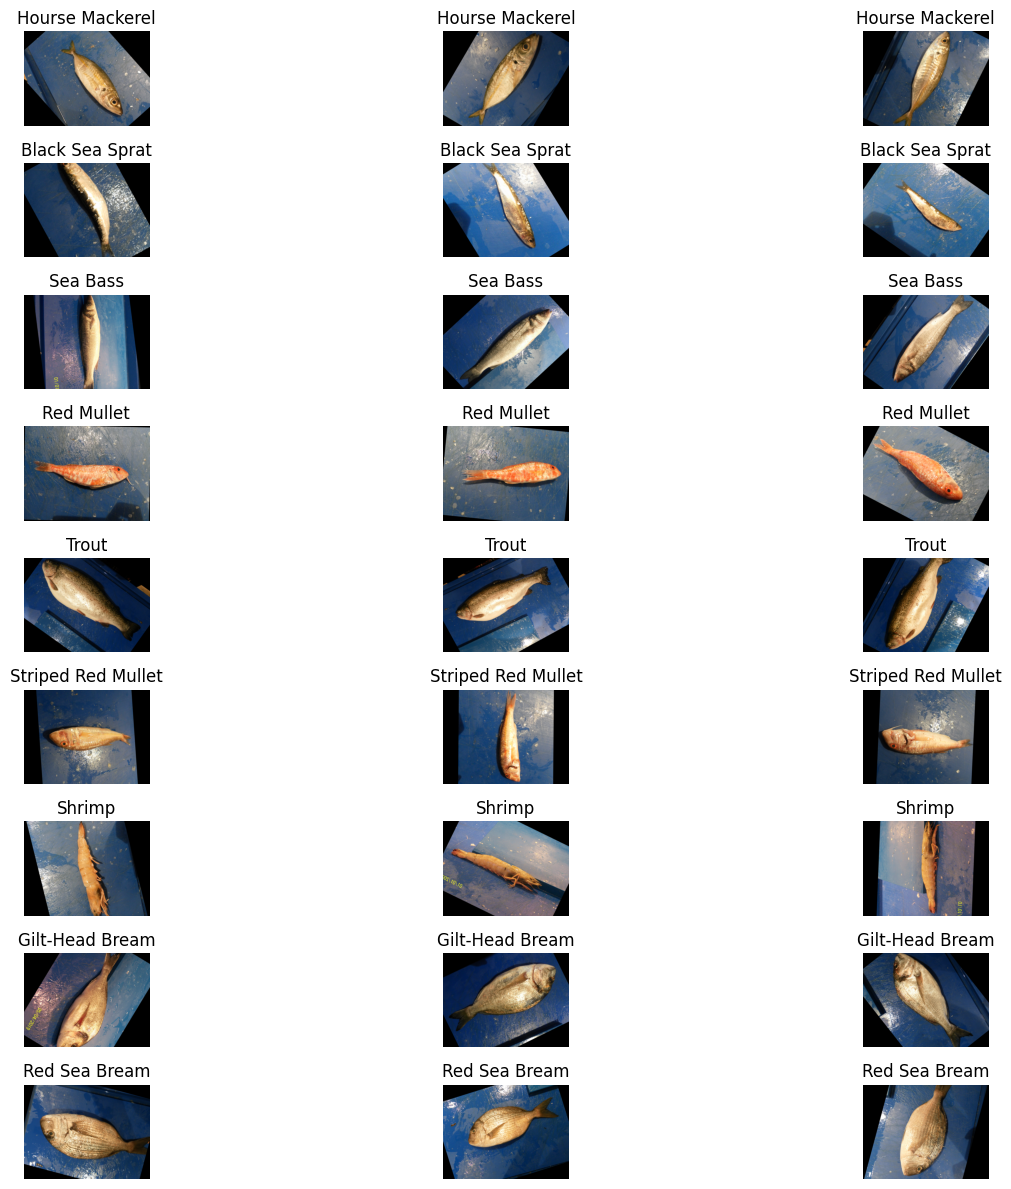

In [10]:
plt.figure(figsize=(15, 12))
num_images_per_label = 3 
idx = 0

for unique_label in data['label'].unique():
    # İlgili etiket için görüntüleri al
    images = data[data['label'] == unique_label].iloc[:num_images_per_label, 0]
    
    for img_path in images:
        plt.subplot(len(data['label'].unique()), num_images_per_label, idx + 1)
        plt.imshow(plt.imread(img_path))
        plt.title(unique_label)
        plt.axis('off')
        idx += 1

plt.tight_layout()  
plt.show()

# Sınıfların Dağılımı Grafiği

In [11]:

# Sınıf sayımlarını al
data_counts = data['label'].value_counts()
data_values = data_counts.values
labels = data_counts.index

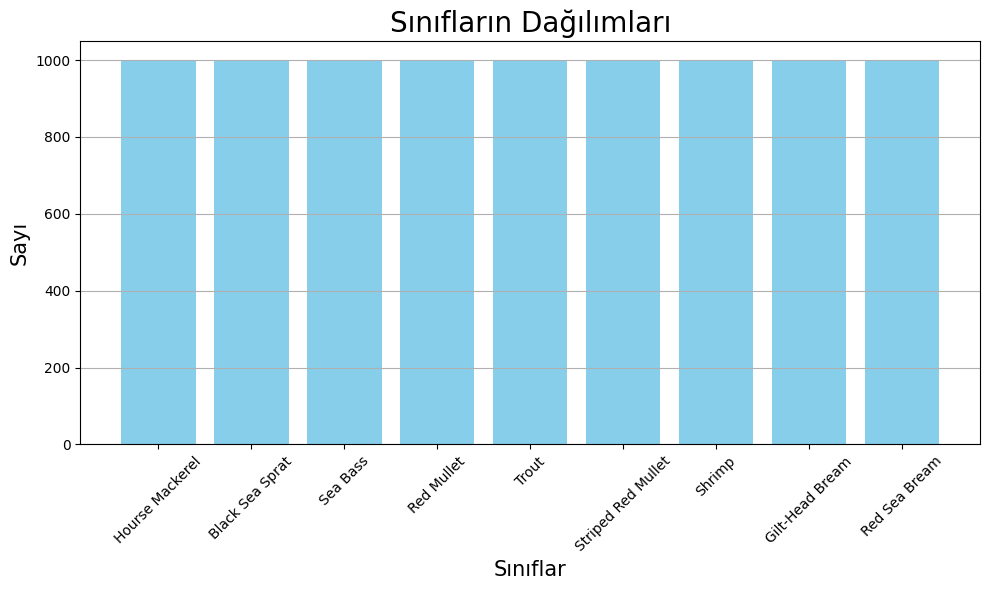

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(labels, data_values, color='skyblue')
plt.title('Sınıfların Dağılımları', size=20)
plt.xlabel('Sınıflar', size=15)
plt.ylabel('Sayı', size=15)
plt.xticks(rotation=45)  # X eksenindeki etiketleri döndür
plt.grid(axis='y')  # Y eksenine ızgara çizgileri ekle
plt.tight_layout()  # Grafik düzenini ayarla
plt.show()

# Veri Setini Eğitim ve Test Olarak Ayırma

In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)


# Görüntü Verilerini Ön İşleme

In [15]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,    
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2    
)

test_generator = ImageDataGenerator(rescale=1./255)

In [16]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='training'
)
val_images = val_generator.flow_from_dataframe(
    dataframe=train_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True, 
    seed=42, 
    subset='validation' 
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_data, 
    x_col='path', 
    y_col='label', 
    target_size=(28, 28), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False 
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


# ANN MODELİ OLUŞTURMA VE EĞİTME

## Modelin genel yapısı

In [17]:

# Sinir ağı modelinin tanımlanması
model = tf.keras.models.Sequential()

# Giriş katmanı: 28x28x3 boyutundaki görüntüleri düzleştirir
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 3))) 

# İlk yoğun katman: 1024 nöron
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())  # Normalizasyon katmanı
model.add(tf.keras.layers.Dropout(0.2))  # Aşırı öğrenmeyi önlemek için Dropout

# İkinci yoğun katman: 512 nöron
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())  # Normalizasyon katmanı

# Üçüncü yoğun katman: 256 nöron
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))  # Aşırı öğrenmeyi önlemek için Dropout

# Dördüncü yoğun katman: 128 nöron
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

# Beşinci yoğun katman: 64 nöron
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.2))  # Aşırı öğrenmeyi önlemek için Dropout

# Altıncı yoğun katman: 32 nöron, ReLU aktivasyonu ve L2 düzenleyici
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

# Yedinci yoğun katman: 16 nöron, ReLU aktivasyonu ve L2 düzenleyici
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

# Çıkış katmanı: 9 sınıf için softmax aktivasyonu
model.add(tf.keras.layers.Dense(9, activation='softmax'))


## Modeli Derleme

In [18]:
# Erken durdurma
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Doğrulama kaybını izler
    patience=5,          # 5 dönem boyunca iyileşme olmazsa durur
    restore_best_weights=True  # En iyi ağırlıkları geri yükler
)

# Öğrenme oranı zamanlayıcısı fonksiyonu
def lr_scheduler(epoch, lr):
    if epoch >= 20:
        lr *= 0.990  # 20. dönemden itibaren öğrenme oranını azaltır
    return lr

# Öğrenme oranı zamanlayıcı geri bildirimi
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Modeli derleme
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),  # Adagrad optimizasyon algoritması
    loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma için kayıp fonksiyonu
    metrics=['accuracy', 'precision', 'recall', 'F1Score']  # Model değerlendirme metrikleri
)


## Modeli Eğitme

In [22]:
results = model.fit(
    train_images, 
    epochs=10, 
    batch_size=64, 
    validation_data=val_images,
    callbacks=[early_stopping,lr_scheduler_callback]
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 85s 891ms/step - F1Score: 0.9318 - accuracy: 0.9319 - loss: 2.7626 - precision: 0.9450 - recall: 0.9165 - val_F1Score: 0.8305 - val_accuracy: 0.8292 - val_loss: 3.0511 - val_precision: 0.8481 - val_recall: 0.8104 - learning_rate: 0.0100
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - F1Score: 0.9393 - accuracy: 0.9397 - loss: 2.7014 - precision: 0.9529 - recall: 0.9298 - val_F1Score: 0.8711 - val_accuracy: 0.8729 - val_loss: 2.8948 - val_precision: 0.8988 - val_recall: 0.8639 - learning_rate: 0.0100
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - F1Score: 0.9474 - accuracy: 0.9478 - loss: 2.6539 - precision: 0.9593 - recall: 0.9363 - val_F1Score: 0.9010 - val_accuracy: 0.9007 - val_loss: 2.7977 - val_precision: 0.9118 - val_recall: 0.8826 - learning_rate: 0.0100
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 850ms/step - F1Score: 0.9524 - accuracy: 0.9526 - loss: 2.6255 - precision: 0.9612 - recall: 0.9437 - val_F1Score: 0.8203 - val_accur

# Grafik çizimleri

## Loss Grafiği

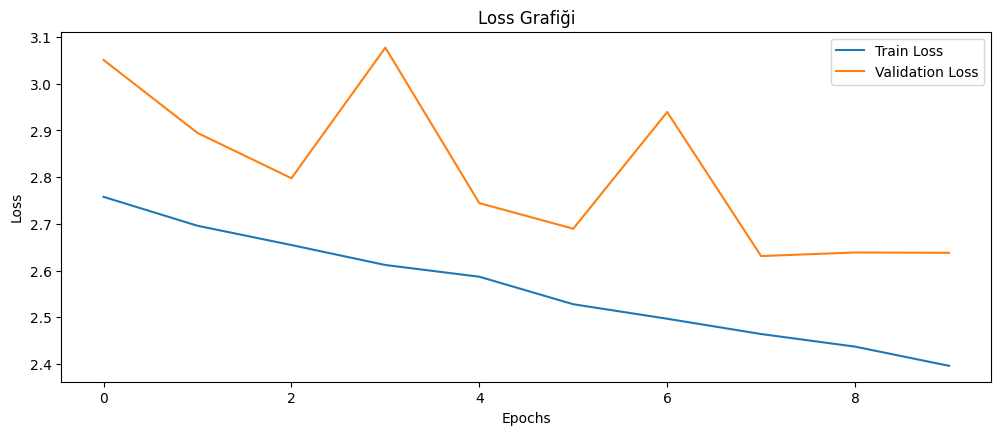

In [23]:
plt.figure(figsize=(12, 10))  # Yüksekliği artırdık

# Loss değeri için grafikleri çizdirelim.
plt.subplot(2, 1, 1)  # 2 satır, 1 sütun, 1. grafik
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## Accuracy Grafiği

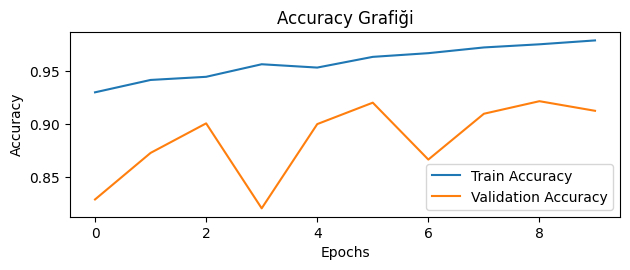

In [24]:
# Accuracy score grafikleri çizdirelim.
plt.subplot(2, 1, 2)  # 2 satır, 1 sütun, 2. grafik
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model ile Tahmin Yapma

In [25]:
# Test verileri üzerinde tahmin yapma
pred = model.predict(test_images)

# Tahmin edilen sınıf etiketlerini alma
pred_classes = np.argmax(pred, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step


## Tahminin Değerlendirilmesi

In [26]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_images)

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 693ms/step - F1Score: 0.9014 - accuracy: 0.9020 - loss: 2.7164 - precision: 0.9130 - recall: 0.8940


# Konfüzyon Matrisi

In [27]:
# Gerçek sınıf etiketlerini alma
true_classes = test_images.classes

# Konfüzyon matrisini hesaplama
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Sınıf etiketlerini alma
class_labels = list(test_images.class_indices.keys())


## Konfüzyon Matrisini Görselleştirme

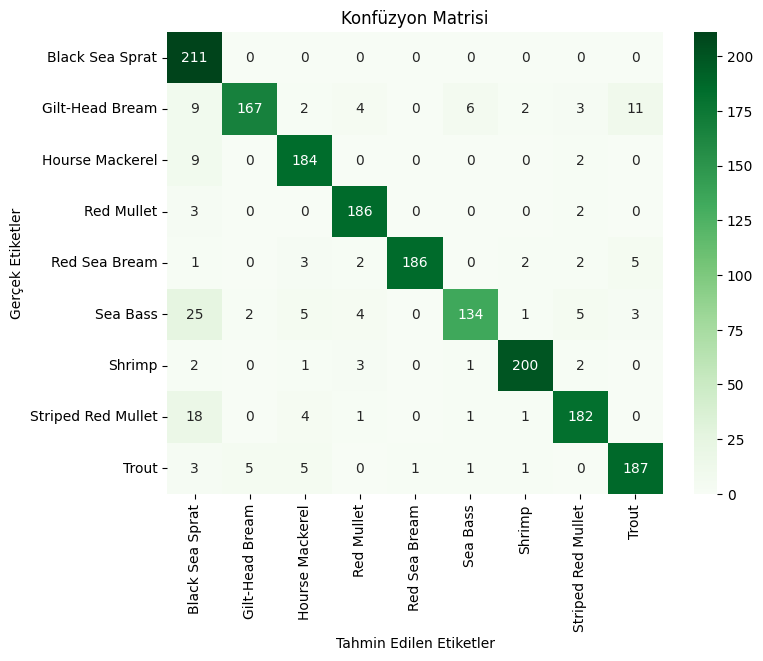

In [28]:
# Konfüzyon matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)  # Renk değiştirildi
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Konfüzyon Matrisi')
plt.show()